# Trust region policy optimization

Let $\pi$ denote a stochastic policy, and let $\eta(\pi)$ represent its expected reward, given by

$$
\eta(\pi) = \mathbb{E}_{\tau \sim p_{\pi}(\tau)} \left[ \sum_{t \geq 0} \gamma^t r_t \right].
$$

Suppose we make an update from $\pi$ to $\tilde{\pi}$. The new expected reward can be expressed in terms of the old expected reward as follows:

$$
\begin{align*}
\eta(\tilde{\pi}) &= \eta(\pi) + \mathbb{E}_{\tau \sim p_{\tilde{\pi}}(\tau)} \left[ \sum_{t \geq 0} \gamma^t A_{\pi}(\mathbf{s}_t, \mathbf{a}_t) \right] \\
&= \eta(\pi) + \sum_{t \geq 0} \sum_{s \in \mathcal{S}} p(\mathbf{s}_t = \mathbf{s} \mid \tilde{\pi}) \sum_{a \in \mathcal{A}} \tilde{\pi}(\mathbf{a} \mid \mathbf{s}) \gamma^t A_{\pi}(\mathbf{s}, \mathbf{a}) \\
&= \eta(\pi) + \sum_{s \in \mathcal{S}} \sum_{t \geq 0} \gamma^t p(\mathbf{s}_t = \mathbf{s} \mid \tilde{\pi}) \sum_{a \in \mathcal{A}} \tilde{\pi}(\mathbf{a} \mid \mathbf{s}) A_{\pi}(\mathbf{s}, \mathbf{a}) \\
&= \eta(\pi) + \sum_{s \in \mathcal{S}} \rho_{\tilde{\pi}}(\mathbf{s}) \sum_{a \in \mathcal{A}} \tilde{\pi}(\mathbf{a} \mid \mathbf{s}) A_{\pi}(\mathbf{s}, \mathbf{a}),
\end{align*}
$$

where $\rho_{\tilde{\pi}}$ denotes the discounted visitation frequency:

$$
\rho_{\tilde{\pi}}(\mathbf{s}) = \sum_{t \geq 0} \gamma^t p(\mathbf{s}_t = \mathbf{s} \mid \tilde{\pi}).
$$

This suggests that, given a current policy $\pi$, to make an update, we can try to find $\tilde{\pi}$ that maximizes the expression above. However, optimizing this directly can be challenging. Instead, we use the following approximation:

$$
\mathcal{L}_{\pi}(\tilde{\pi}) = \eta(\pi) + \sum_{s \in \mathcal{S}} \rho_{\pi}(\mathbf{s}) \sum_{a \in \mathcal{A}} \tilde{\pi}(\mathbf{a} \mid \mathbf{s}) A_{\pi}(\mathbf{s}, \mathbf{a}),
$$

where we replace the visitation frequency of the new policy with that of the old policy. This approximation is accurate in the sense that it matches $\eta$ to first order:

$$
\begin{align*}
\mathcal{L}_{\pi_{\theta_0}} (\pi_{\theta_0}) &= \eta(\pi_{\theta_0}), \\
\nabla_{\theta} \mathcal{L}_{\pi_{\theta_0}} (\pi_{\theta}) \bigg|_{\theta = \theta_0} &= \nabla_{\theta} \eta (\pi_{\theta}) \bigg|_{\theta = \theta_0}.
\end{align*}
$$

This means that optimizing $\mathcal{L}_{\pi}$ will improve the expected reward $\eta$ as long as the step size isn't too large. However, it remains unclear how small the step size should be. In 2017, Schulman et al., in their paper "Trust Region Policy Optimization," proved the following bound that provides insights into how different step sizes influence the expected reward.

````{prf:theorem} Improvement bound
:label: my-theorem

Let 

$$\alpha=D_{TV}^{\text{max}}(\pi_{old}, \pi_{new})=\max_{\mathbf{s}\in \mathcal{S}} D_{TV}(\pi_{old}(\cdot|\mathbf{s})||\pi_{new}(\cdot|\mathbf{s}))$$

Then we have 

$$\eta(\pi_{new}) \geq \mathcal{L}_{\pi_{old}}(\pi_{new}) - \frac{4\epsilon\gamma}{(1-\gamma)^2}\alpha^2$$

Where $\epsilon = \max_{\mathbf{s}, \mathbf{a}}|A_{\pi}(\mathbf{s}, \mathbf{a})|$
````

````{prf:proof}
To be added
````

The above theorem suggests that if the step size, measured in total variation distance, is small, then $\mathcal{L}_{\pi}$ is a tight lower bound of the original objective. We can also use a different distance measure, for example, the KL-divergence. Using the fact that $D_{KL}(p||q)^2\leq D_{KL}(p||q)$, we have

$$\eta(\pi_{new}) \geq \mathcal{L}_{\pi_{old}}(\pi_{new}) - CD_{KL}^{\text{max}}(\pi_{old}, \pi_{new}) \hspace{5mm}\text{where}\hspace{5mm} C= \frac{4\epsilon \gamma}{(1-\gamma)^2}$$

This lower bound motivates a policy iteration-like algorithm that generates a sequence of monotonically improving policies, as shown in the pseudocode below. 

```{prf:algorithm} Policy iteration algorithm
:label: my-theorem

**Inputs** Initialized policy $\pi_0$

1. For $i=1, 2,...$ until convergence:
	1. Estimate advantage function $A_{\pi_i}(\mathbf{s}, \mathbf{a})$
	2. Update policy by solving the optimization problem
    
    $$\pi_{i+1} = \underset{\pi}{\text{argmax}}\;\mathcal{L}_{\pi_i}(\pi) - CD_{KL}^{\text{max}}(\pi_{i}, \pi)$$
```

To see why the above algorithm generates monotonically improving policy, let $M_i(\pi)=\mathcal{L}_{\pi_i}(\pi) - CD_{KL}^{\text{max}}(\pi_{i}, \pi)$, then by definition $\eta(\pi_{i+1})\geq M_i(\pi_{i+1})$. Since $\mathcal{L}_{\pi}$ matches $\eta$ to first order, we also have $\eta(\pi_i) = M_i(\pi_i)$. This suggests that

$$\eta(\pi_{i+1}) - \eta(\pi_i) \geq M_i(\pi_{i+1}) - M_i(\pi_i)\geq 0$$

Even though the algorithm above is theoretically sound, solving the optimization problem in practice can be challenging. Therefore, it is often necessary to approximate the function to make the problem tractable.

## Natural policy gradient

We now replace the policies $\pi$ with their corresponding parameters $\theta$ in the notation above. Solving the optimization problem directly 

$$\max_{\theta}\;\mathcal{L}_{\theta_{old}}(\theta) - CD_{KL}^{\text{max}}(\theta_{old},\theta)$$

in practice usally results in small update, to make more larger and more robust updates, the authors proposed solving 

$$\max_{\theta}\;\mathcal{L}_{\theta_{old}}(\theta)\hspace{5mm}\text{subject to}\hspace{5mm}D_{KL}^{\text{max}}(\theta_{old},\theta)\leq \delta$$

We will now discuss two simplifications to the optimization problem.

### 1. Average KL divergence

In the optimization problem above, we need to ensure that the KL divergence on each state $\mathbf{s}\in \mathcal{S}$ is smaller than $\delta$. This is intractable when the state space is large (lots of constraints!). TO address this, the authors proposed using average KL-divergence

$$\overline{D}_{KL}^{\rho}(\theta_1, \theta_2) = \mathbb{E}_{\mathbf{s}\sim \rho}[D_{KL}(\pi_{\theta_1}(\cdot|\mathbf{s})||\pi_{\theta_2}(\cdot|\mathbf{s}))] \approx \frac{1}{N}\sum_{i=1}^N D_{KL}(\pi_{\theta_1}(\cdot|\mathbf{s}_i)||\pi_{\theta_2}(\cdot|\mathbf{s}_i))$$

This is now managable since we can compute it using trajectory samples. 

### 2. Linearize objective and constraint

The second simplification we can make is to linearize both objective and constraint, this gives us

$$
\begin{align*}
&\mathcal{L}_{\theta_k}(\theta) \approx \mathcal{L}_{\theta_k}(\theta_k) + g^T (\theta-\theta_k)+...\\
&\overline{D}_{KL}(\theta, \theta_k) \approx \overline{D}_{KL}(\theta_k, \theta_k) +\nabla_{\theta} \overline{D}_{KL}(\theta, \theta_k)|_{\theta=\theta_k}(\theta-\theta_k) + \frac{1}{2}(\theta-\theta_k)^TH(\theta-\theta_k)+...
\end{align*}
$$

Where $g$ denote the gradient of $\mathcal{L}_{\theta_k}$ and $H$ denote the Hessian matrix of the KL-divergence term. Some of these terms of zero, simplifying gives us

$$
\begin{align*}
&\mathcal{L}_{\theta_k}(\theta) \approx g^T (\theta-\theta_k)\\
&\overline{D}_{KL}(\theta, \theta_k) \approx  \frac{1}{2}(\theta-\theta_k)^TH(\theta-\theta_k)
\end{align*}
$$

Now our optimization becomes

$$\max_{\theta}\;g^T (\theta-\theta_k) \hspace{5mm}\text{subject to}\hspace{5mm} \frac{1}{2}(\theta-\theta_k)^TH(\theta-\theta_k)\leq \delta$$

This is a linear programming problem with quadratic constraint! It can be solved analytically

$$\theta_{k+1} = \theta_{k} + \sqrt{\frac{2\delta }{g^T H^{-1}g}}H^{-1}g$$

This motivates the natural policy gradient algorithm, presented below


```{prf:algorithm} Natural policy gradient
:label: natural-policy-gradient

**Inputs** Initialized policy $\pi_0$

1. For $i=1, 2,...$ until convergence:
	1. Collect set of trajectories from $\pi_{\theta_i}$
	2. Estimate advantage function $A_{\pi_i}(\mathbf{s}, \mathbf{a})$
    3. Find sample estimates for $g_i, H_i$
    4. Update policy parameter based on 
    
    $$\theta_{i+1} = \theta_{i} + \sqrt{\frac{2\delta }{g_i^T H_i^{-1}g_i}}H_i^{-1}g_i$$
```

## Truncated natural policy gradient

Note that to perform policy update, we need to estimate the inverse of the Hessian matrix, this is numerically unstable thing to do. Instead of computing the inverse, we can consider solve 

$$Hx=g \implies x=H^{-1}g$$

There are lots of algorithms for solving linear system. One popular choice is the conjugate gradient descent method. Once the solution $x$ has been found, the update rule is then 

$$\theta_{k+1} = \theta_{k} + \sqrt{\frac{2\delta }{g^T x}}x$$

Which is a much more stable problem! We adjust our psuedocode based on this change

```{prf:algorithm} Truncated natural policy gradient
:label: truncated-natural-policy-gradient

**Inputs** Initialized policy $\pi_0$

1. For $i=1, 2,...$ until convergence:
	1. Collect set of trajectories from $\pi_{\theta_i}$
	2. Estimate advantage function $A_{\pi_i}(\mathbf{s}, \mathbf{a})$
    3. Find sample estimates for $g_i, H_i$
    4. Use conjugate gradient descent to solve $H_ix_i=g_i$
    4. Update policy parameter based on 
    
    $$\theta_{i+1} = \theta_{i} + \sqrt{\frac{2\delta }{g_i^T x_i}}x_i$$
```

## Trust region policy optimization (TRPO)

Our final touch to the algorithm is to note that we've made lots of estimates in the algorithm. This means that due to estimation error, it is very likely that the update step brings out out of the trust region. To address this issue, TRPO algorithm added another backtracking line search. It starts from the maximium step and gradually reduce the step to see whether their is a better step. The psuedocode is shown below

```{prf:algorithm} Backtracking line search
:label: line-search

**Inputs** $\alpha\in (0,1)$, proposed step size

$$\Delta_k = \sqrt{\frac{2\delta }{g_k^T x_k}}x_k$$

1. For $i=1, 2,..., L$:
	1. Compute potential update $\theta \leftarrow \theta + \alpha^i \Delta_i$
	2. If $\mathcal{L}_{\theta_i}(\theta) \geq 0$ and $\overline{D}_{KL}(\theta||\theta_i)\leq \delta$
        1. Accept update
        2. Break
```

The TRPO algorithm includes backtracking line search in the last step

```{prf:algorithm} Trust region policy optimization
:label: trpo

**Inputs** Initialized policy $\pi_0$

1. For $i=1, 2,...$ until convergence:
	1. Collect set of trajectories from $\pi_{\theta_i}$
	2. Estimate advantage function $A_{\pi_i}(\mathbf{s}, \mathbf{a})$
    3. Find sample estimates for $g_i, H_i$
    4. Use conjugate gradient descent to solve $H_ix_i=g_i$
    4. Compute proposed update
    
    $$\theta_{i+1} = \theta_{i} + \sqrt{\frac{2\delta }{g_i^T x_i}}x_i$$
    
    5. Perform backtracking line search to find optimal step size
    6. Update policy parameter
```

## TRPO Implementation

We now implement the TRPO algorithm and test its performance on cartpole enviroment. For the policy and value function, we use a one-layer neural network with hidden units of $128$. For the advantage, we use generalized advantage estimation algorithm. 

In [ ]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
from tqdm import tqdm
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import torch.nn.utils as utils
import pyvirtualdisplay
import base64
import io
from IPython import display as ipythondisplay
import imageio
from datetime import datetime
from stable_baselines3 import PPO
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
import logging

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
gym.logger.set_level(logging.ERROR)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Policy, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, final_layer="Softmax", n_layers=1)

    def forward(self, obs):
        return self.net(obs)

    def select_action(self, state):
        state = torch.tensor(state).float().to(DEVICE)
        action_prob = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_prob)
        action = action_dist.sample()
        return action.long()

    def get_action_log_prob(self, state, action):
        state = torch.tensor(state).float().to(DEVICE)
        return torch.log(self.net(state).gather(1, action.long()))

class Value(nn.Module):
    def __init__(self, state_dim, hidden_dim=128):
        super(Value, self).__init__()
        self.state_dim = state_dim
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, n_layers=1)

    def forward(self, state):
        return self.net(state)

In [ ]:
class TRPOAgent(Agent):
    def __init__(self, env, hidden_dim, lmbda, delta, alpha, lr, gamma, device="cpu"):
        self.env = env
        state_dim, action_dim = env.observation_space.shape[0], env.action_space.n
        self.policy = Policy(state_dim, action_dim, hidden_dim).to(device)
        self.value = Value(state_dim, hidden_dim).to(device)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.delta = delta
        self.alpha = alpha
        self.device = device
        
    def compute_advantage(self, deltas):
        deltas = deltas.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in deltas[::-1]:
            advantage = delta + self.gamma * self.lmbda * advantage
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

    def hessian_product(self, states, old_dists, vector):
        new_dist = torch.distributions.Categorical(self.policy(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_dists, new_dist))
        kl_grad = torch.autograd.grad(kl, self.policy.parameters(), create_graph=True)
        kl_grad = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_product = torch.dot(kl_grad, vector)
        hessian_matrix_product = torch.autograd.grad(kl_grad_product, self.policy.parameters())
        hessian_matrix_product = torch.cat([grad.view(-1) for grad in hessian_matrix_product])
        return hessian_matrix_product

    def conjugate_gradient(self, g, states, old_dists, max_steps=10, tol=1e-9):
        r = p = g.clone()
        x = torch.zeros_like(g)
        r_r = torch.dot(r, r)
        for i in range(max_steps):
            Hp = self.hessian_product(states, old_dists, p)
            alpha = r_r / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_r_r = torch.dot(r, r)
            if new_r_r < tol:
                break
            p = r + new_r_r * p / r_r
            r_r = new_r_r
        return x

    def surrogate(self, states, actions, advantage, old_log_probs, policy):
        new_log_probs = policy.get_action_log_prob(states, actions)
        ratio = torch.exp(new_log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs, old_dists, max_direction, max_steps=10):
        old_param = torch.nn.utils.convert_parameters.parameters_to_vector(self.policy.parameters())
        old_surrogate = self.surrogate(states, actions, advantage, old_log_probs, self.policy)
        for i in range(max_steps):
            new_param = old_param + self.alpha ** i * max_direction
            new_policy = copy.deepcopy(self.policy)
            torch.nn.utils.convert_parameters.vector_to_parameters(new_param, new_policy.parameters())
            new_dists = torch.distributions.Categorical(new_policy(states))
            kl= torch.mean(torch.distributions.kl.kl_divergence(old_dists, new_dists))
            new_surrogate = self.surrogate(states, actions, advantage, old_log_probs, new_policy)
            if new_surrogate > old_surrogate and kl < self.delta:
                return new_param
        return old_param

    def learn_episode(self, *param):
        max_steps = param[0]
        states, actions, rewards, next_states, dones = self.sample_trajectory(self.env, self.policy, self.gamma, max_steps=max_steps, device=self.device)

        ## 1. Update value function
        with torch.no_grad():
            target = rewards + self.gamma * (1 - dones) * self.value(next_states)
        value_loss = torch.mean(F.mse_loss(self.value(states), target))
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        ## 2. Compute surrogate gradient (g)
        td_target = target - self.value(states)
        advantage = self.compute_advantage(td_target, self.gamma, self.lmbda).to(self.device)
        old_log_probs = self.policy.get_action_log_prob(states, actions).detach()
        old_dists = torch.distributions.Categorical(self.policy(states).detach())
        surrogate = self.surrogate(states, actions, advantage, old_log_probs, self.policy)
        surrogate_grad = torch.autograd.grad(surrogate, self.policy.parameters())
        surrogate_grad = torch.cat([grad.view(-1) for grad in surrogate_grad]).detach()

        ## 3. Compute direction using conjugate gradient search
        direction = self.conjugate_gradient(surrogate_grad, states, old_dists)
        H = self.hessian_product(states, old_dists, direction)
        max_step = torch.sqrt(2 * self.delta / (torch.dot(direction, H) + 1e-8))

        ## 4. Use line search to find optimal updates
        new_param = self.line_search(states, actions, advantage, old_log_probs, old_dists, direction * max_step)
        torch.nn.utils.convert_parameters.vector_to_parameters(new_param, self.policy.parameters())
        return value_loss.item(), torch.sum(rewards).item()

In [ ]:
env_name = 'CartPoleBulletEnv-v1'
env = gym.make(env_name)
agent = TRPOAgent(env, hidden_dim=128, lmbda=0.95, delta=0.0005, alpha=0.5, value_lr=1e-2, gamma=1, device=DEVICE)
history = agent.learn(num_episodes, 10000)

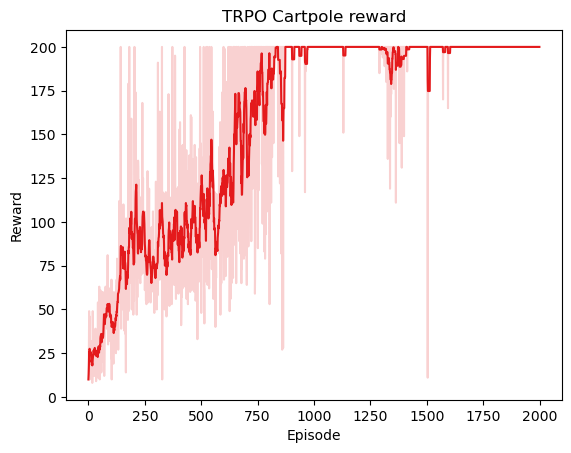

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/trpo/trpo_cartpole.npy")]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 10), c=colors[i])
plt.title("TRPO Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

<span style="font-size:20px;"><strong>Citations</strong></span>

[1] https://arxiv.org/abs/1502.05477